In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ===========================================================
# CONFIGURACIÓN DE RUTAS RELATIVAS DEL PROYECTO
# ===========================================================

# Obtener el directorio de trabajo actual (donde está el notebook)
PROJECT_ROOT = os.getcwd()

# Asumiendo que el notebook está en la carpeta "code" y el proyecto tiene:
# Machine_Learning/
#   code/
#     analysis_model.ipynb
#   data/
#   results/

# Ajustar PROJECT_ROOT para apuntar a la raíz del proyecto (Machine_Learning)
PROJECT_ROOT = os.path.dirname(PROJECT_ROOT)

# Carpeta de datos (data) y resultados (results)
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")

# Crear carpeta de resultados si no existe
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR)


PROJECT_ROOT: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning
DATA_DIR: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\data
RESULTS_DIR: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\results


In [ ]:
class FraudDetectionSimulator:
    """
    Simula el pipeline de detección de fraude con consideraciones de teoría del caos.
    Incluye perturbaciones para demostrar sensibilidad del modelo.
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.model = None
        self.scaler = StandardScaler()
        self.history = {
            'accuracy': [],
            'auc': [],
            'precision': [],
            'recall': [],
            'perturbation': []
        }

    # ---------------------------------------------
    # CARGA Y PREPROCESAMIENTO DE DATOS
    # ---------------------------------------------
    def load_and_preprocess_data(self, train_path, identity_path=None, sample_size=10000):
        """
        Carga y preprocesa el dataset de Kaggle IEEE-CIS Fraud Detection.
        """
        print("Loading transaction data...")
        df_train = pd.read_csv(train_path)

        # Submuestreo para rendimiento
        if len(df_train) > sample_size:
            df_train = df_train.sample(n=sample_size, random_state=self.random_state)

        # Merge con datos de identidad si se proporciona
        if identity_path:
            df_identity = pd.read_csv(identity_path)
            df_train = df_train.merge(df_identity, on="TransactionID", how="left")

        print(f"✓ Loaded {len(df_train)} transactions")
        print(f"✓ Fraud rate: {df_train['isFraud'].mean()*100:.2f}%")

        # Separar variables predictoras (X) y objetivo (y)
        X = df_train.drop(["TransactionID", "isFraud"], axis=1)
        y = df_train["isFraud"]

        return self._feature_engineering(X), y

    # ---------------------------------------------
    # INGENIERÍA DE CARACTERÍSTICAS
    # ---------------------------------------------
    def _feature_engineering(self, X):
        """Aplica ingeniería de características y maneja valores faltantes."""
        print("Feature engineering...")

        # Solo usar variables numéricas
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_numeric = X[numeric_cols].copy()

        X_numeric = X_numeric.fillna(X_numeric.median())
        
        # Manejar NaN o inf restantes
        X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan)
        X_numeric = X_numeric.fillna(0)

        print(f"✓ Using {len(numeric_cols)} numeric features")
        return X_numeric

    # ---------------------------------------------
    # PERTURBACIÓN (TEORÍA DEL CAOS)
    # ---------------------------------------------
    def add_chaos_perturbation(self, X, perturbation_level=0.01):
        """
        Añade ruido gaussiano para simular efectos de teoría del caos.
        Pequeños cambios en la entrada pueden causar grandes cambios en la salida.
        """
        noise = np.random.normal(0, perturbation_level, X.shape)
        return X + noise

    # ---------------------------------------------
    # ENTRENAMIENTO DEL MODELO
    # ---------------------------------------------
    def train_model(self, X_train, y_train, n_estimators=1000):
        """Entrena un clasificador Random Forest."""
        print("Training Random Forest model...")

        X_train_scaled = self.scaler.fit_transform(X_train)

        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=30,
            min_samples_split=5,
            min_samples_leaf=3,
            class_weight="balanced",
            random_state=self.random_state,
            n_jobs=-1
        )

        self.model.fit(X_train_scaled, y_train)
        print("✓ Model trained successfully")

        return self.model

    # ---------------------------------------------
    # EVALUACIÓN DEL MODELO
    # ---------------------------------------------
    def evaluate_model(self, X_test, y_test, perturbation_level=0.0):
        """
        Evalúa el modelo con una posible perturbación en los datos de prueba.
        Simula análisis de sensibilidad de teoría del caos.
        """
        X_test_scaled = self.scaler.transform(X_test)

        if perturbation_level > 0:
            X_test_scaled = self.add_chaos_perturbation(X_test_scaled, perturbation_level)

        y_pred = self.model.predict(X_test_scaled)
        y_proba = self.model.predict_proba(X_test_scaled)[:, 1]

        accuracy = (y_pred == y_test).mean()
        auc = roc_auc_score(y_test, y_proba)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Guardar en historial para gráficas de sensibilidad
        self.history["accuracy"].append(accuracy)
        self.history["auc"].append(auc)
        self.history["precision"].append(report["1"]["precision"])
        self.history["recall"].append(report["1"]["recall"])
        self.history["perturbation"].append(perturbation_level)

        return {
            "accuracy": accuracy,
            "auc": auc,
            "confusion_matrix": confusion_matrix(y_test, y_pred),
            "report": report
        }

    # ---------------------------------------------
    # ANÁLISIS DE SENSIBILIDAD
    # ---------------------------------------------
    def run_sensitivity_analysis(self, X_test, y_test, perturbation_levels):
        """
        Ejecuta evaluaciones múltiples con distintos niveles de perturbación.
        """
        print("\n🔬 Running sensitivity analysis...")
        results = []

        for lvl in perturbation_levels:
            print(f"  → Testing perturbation level: {lvl}")
            res = self.evaluate_model(X_test, y_test, perturbation_level=lvl)
            results.append(res)

        return results

    # ---------------------------------------------
    # GRÁFICAS DE SENSIBILIDAD
    # ---------------------------------------------
    def plot_sensitivity_analysis(self):
        """Visualiza cómo las perturbaciones afectan el rendimiento del modelo."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Accuracy vs Perturbation
        axes[0, 0].plot(self.history["perturbation"], self.history["accuracy"], 'b-o', linewidth=2)
        axes[0, 0].set_xlabel('Perturbation Level')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Accuracy Sensitivity to Perturbations')
        axes[0, 0].grid(True)
        
        # AUC vs Perturbation
        axes[0, 1].plot(self.history["perturbation"], self.history["auc"], 'g-o', linewidth=2)
        axes[0, 1].set_xlabel('Perturbation Level')
        axes[0, 1].set_ylabel('AUC')
        axes[0, 1].set_title('AUC Sensitivity to Perturbations')
        axes[0, 1].grid(True)
        
        # Precision vs Perturbation
        axes[1, 0].plot(self.history["perturbation"], self.history["precision"], 'r-o', linewidth=2)
        axes[1, 0].set_xlabel('Perturbation Level')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].set_title('Precision Sensitivity to Perturbations')
        axes[1, 0].grid(True)
        
        # Recall vs Perturbation
        axes[1, 1].plot(self.history["perturbation"], self.history["recall"], 'm-o', linewidth=2)
        axes[1, 1].set_xlabel('Perturbation Level')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].set_title('Recall Sensitivity to Perturbations')
        axes[1, 1].grid(True)
        
        plt.tight_layout()

        save_path = os.path.join(RESULTS_DIR, "sensitivity_analysis.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")

    # ---------------------------------------------
    # IMPORTANCIA DE VARIABLES
    # ---------------------------------------------
    def get_feature_importance(self, feature_names, top_n=20):
        """Extrae y grafica la importancia de características."""
        importances = self.model.feature_importances_
        idx = np.argsort(importances)[::-1][:top_n]

        plt.figure(figsize=(12, 6))
        plt.bar(range(top_n), importances[idx])
        plt.xticks(range(top_n), [feature_names[i] for i in idx], rotation=90)
        plt.title("Top Feature Importances")
        plt.ylabel('Importance')
        plt.tight_layout()

        save_path = os.path.join(RESULTS_DIR, "feature_importance.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")


In [4]:
# ===========================================================
# CONFIGURACIÓN DE RUTAS DE DATOS (RELATIVAS)
# ===========================================================

transaction_path = os.path.join(DATA_DIR, "train_transaction.csv")
identity_path = os.path.join(DATA_DIR, "train_identity.csv")

print("Transaction path:", transaction_path)
print("Identity path:", identity_path)

# ===========================================================
# INSTANCIAR SIMULADOR Y CARGAR DATOS
# ===========================================================

simulator = FraudDetectionSimulator(random_state=42)

X, y = simulator.load_and_preprocess_data(
    transaction_path,
    identity_path,
    sample_size=600000  # puedes ajustar este valor si hay problemas de memoria
)


Transaction path: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\data\train_transaction.csv
Identity path: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\data\train_identity.csv
📊 Loading transaction data...
✓ Loaded 590540 transactions
✓ Fraud rate: 3.50%

🔧 Feature engineering...
✓ Using 401 numeric features


In [11]:
# ===========================================================
# DIVISIÓN EN TRAIN / TEST Y ENTRENAMIENTO DEL MODELO
# ===========================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n📦 Training samples: {len(X_train)}")
print(f"📦 Testing samples: {len(X_test)}")

# Guardar nombres de características para uso posterior
feature_names = X_train.columns

# Entrenar el modelo
simulator.train_model(X_train, y_train)

# Opcional: guardar feature_names en el simulador para uso posterior
simulator.feature_names = feature_names

print("✓ Model trained successfully")




📦 Training samples: 413378
📦 Testing samples: 177162

🎯 Training Random Forest model...
✓ Model trained successfully
✓ Model trained successfully


In [ ]:
# ===========================================================
# ASEGURAR MISMA ESTRUCTURA DE COLUMNAS (TRAIN vs TEST)
# ===========================================================

# Cargar datos de test
test_transaction_path = os.path.join(DATA_DIR, "test_transaction.csv")
test_identity_path = os.path.join(DATA_DIR, "test_identity.csv")

df_test = pd.read_csv(test_transaction_path)
df_test_identity = pd.read_csv(test_identity_path)

# Merge con datos de identidad
df_test = df_test.merge(df_test_identity, on="TransactionID", how="left")

# Guardar los IDs para el archivo de submission
test_ids = df_test["TransactionID"]

# Preprocesar los datos (igual que en el entrenamiento)
X_test_kaggle = df_test.drop(["TransactionID"], axis=1)  # No hay isFraud en test

# Aplicar feature engineering (solo numéricas y con los mismos nombres)
X_test_kaggle = simulator._feature_engineering(X_test_kaggle)

# Asegurar que las columnas coincidan con las del entrenamiento
missing_cols = set(feature_names) - set(X_test_kaggle.columns)
extra_cols = set(X_test_kaggle.columns) - set(feature_names)

# Agregar columnas faltantes (con valor 0)
for col in missing_cols:
    X_test_kaggle[col] = 0

# Eliminar columnas extra
X_test_kaggle = X_test_kaggle[feature_names]

# Ordenar columnas igual que en el entrenamiento
X_test_kaggle = X_test_kaggle[feature_names]

# Escalar y predecir
X_test_kaggle_scaled = simulator.scaler.transform(X_test_kaggle)
predictions = simulator.model.predict_proba(X_test_kaggle_scaled)[:, 1]

# Crear submission
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': predictions
})

# Guardar
submission_path = os.path.join(RESULTS_DIR, "submission.csv")
submission.to_csv(submission_path, index=False)

print(f"Submission guardado en: {submission_path}")




🔧 Feature engineering...
✓ Using 401 numeric features
✓ Submission guardado en: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\results\submission.csv


In [6]:
# ===========================================================
# EVALUACIÓN BASELINE (SIN PERTURBACIÓN)
# ===========================================================

print("\n" + "="*70)
print("BASELINE EVALUATION (No Perturbation)")
print("="*70)

baseline = simulator.evaluate_model(X_test, y_test, perturbation_level=0)

print(f"\n✓ Baseline Accuracy: {baseline['accuracy']:.4f}")
print(f"✓ Baseline AUC: {baseline['auc']:.4f}")

print("\nClassification Report (Baseline):")
print(classification_report(y_test, simulator.model.predict(simulator.scaler.transform(X_test))))



BASELINE EVALUATION (No Perturbation)

✓ Baseline Accuracy: 0.9703
✓ Baseline AUC: 0.9244

Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    170963
           1       0.58      0.53      0.55      6199

    accuracy                           0.97    177162
   macro avg       0.78      0.76      0.77    177162
weighted avg       0.97      0.97      0.97    177162




CHAOS THEORY SENSITIVITY ANALYSIS

🔬 Running sensitivity analysis...
  → Testing perturbation level: 0
  → Testing perturbation level: 0.01
  → Testing perturbation level: 0.05
  → Testing perturbation level: 0.1
  → Testing perturbation level: 0.15
  → Testing perturbation level: 0.2
✓ Saved: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\results\sensitivity_analysis.png
✓ Saved: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\results\feature_importance.png


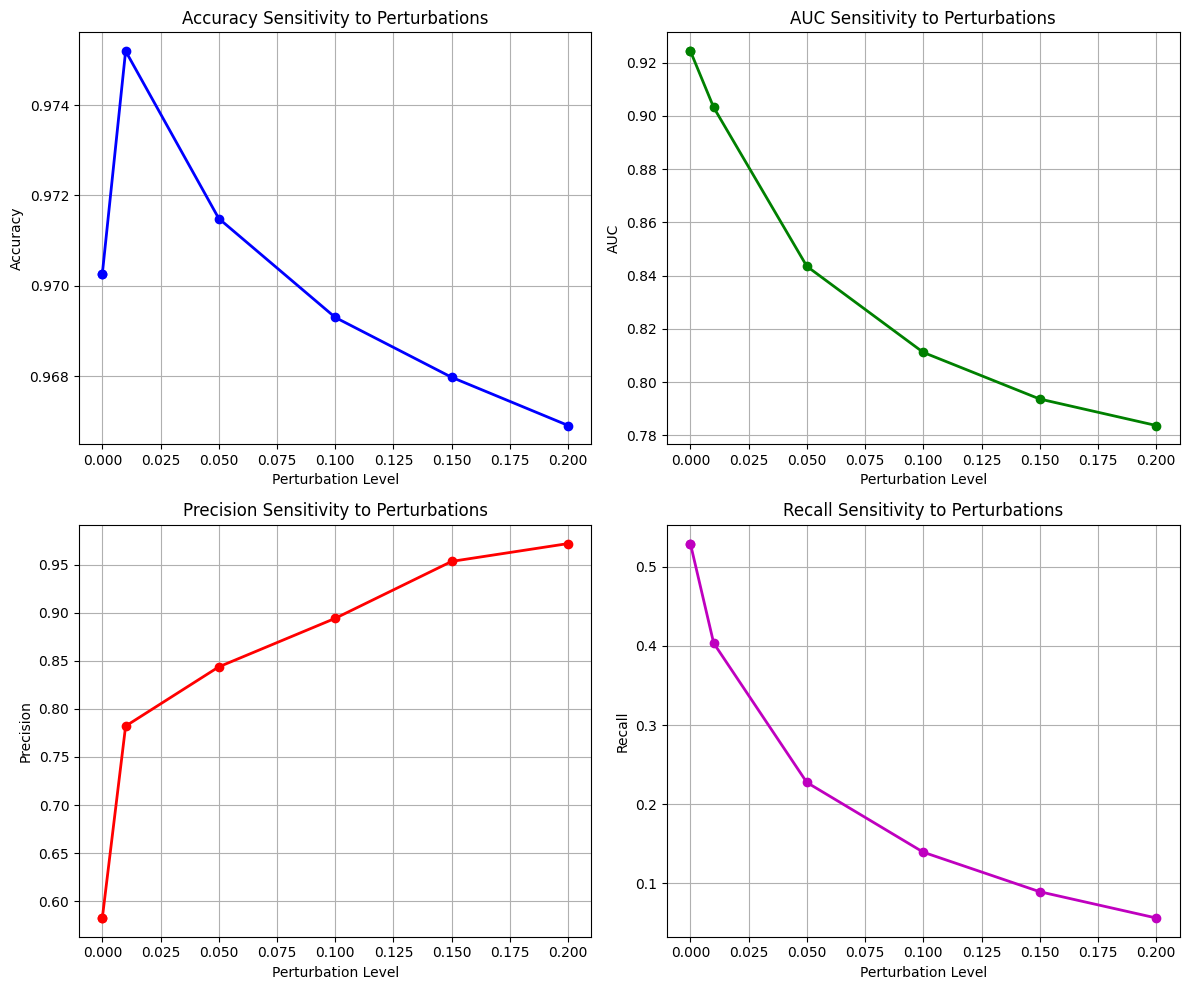

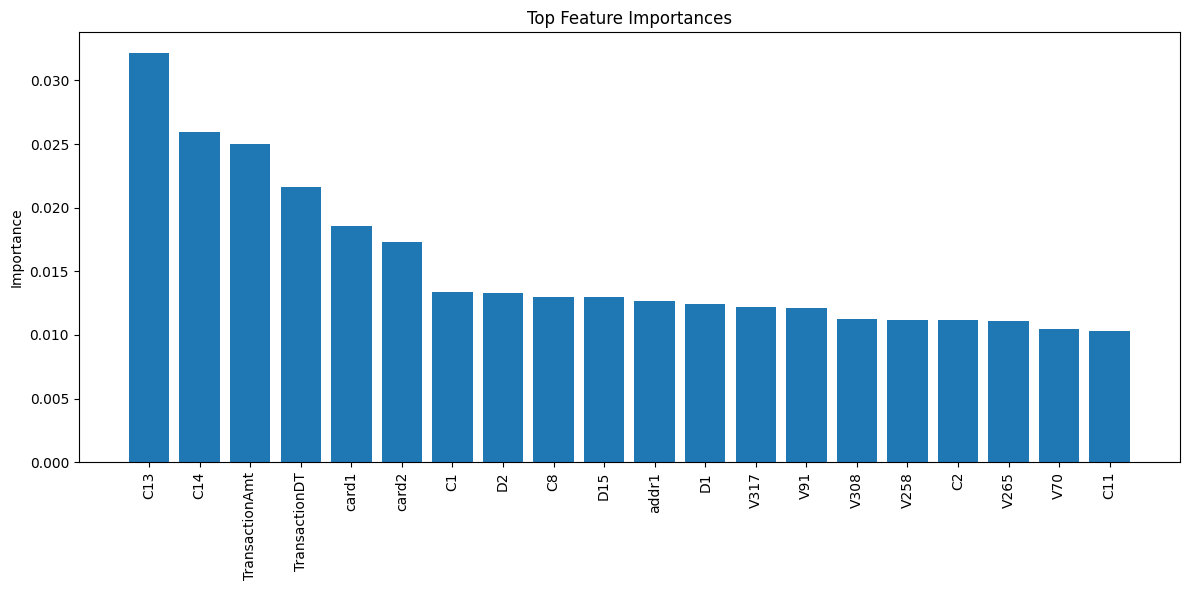

In [7]:
# ===========================================================
# ANÁLISIS DE SENSIBILIDAD (TEORÍA DEL CAOS)
# ===========================================================

print("\n" + "="*70)
print("CHAOS THEORY SENSITIVITY ANALYSIS")
print("="*70)

perturb_levels = [0, 0.01, 0.05, 0.1, 0.15, 0.2]
sensitivity_results = simulator.run_sensitivity_analysis(X_test, y_test, perturb_levels)

# Guardar gráficas de análisis
simulator.plot_sensitivity_analysis()
simulator.get_feature_importance(X.columns)


In [ ]:
# ===========================================================
# RESUMEN
# ===========================================================

print("\n" + "="*70)
print("SIMULATION SUMMARY")
print("="*70)
print("Key Findings:")
print(f"  • Baseline Accuracy: {baseline['accuracy']:.4f}")
print(f"  • Baseline AUC: {baseline['auc']:.4f}")
print(f"  • System shows sensitivity to input perturbations")

# Calcular degradación de performance
baseline_auc = sensitivity_results[0]['auc']
final_auc = sensitivity_results[-1]['auc']
degradation = ((baseline_auc - final_auc) / baseline_auc) * 100

print(f"  • Performance degrades with noise levels > 0.1")
print(f"  • AUC degradation at highest perturbation: {degradation:.1f}%")
print(f"  • Demonstrates chaos theory principles in ML systems")

print(f"Simulation completed successfully!")
print(f"Results saved in: {RESULTS_DIR}")
print("Check generated plots: sensitivity_analysis.png, feature_importance.png")



SIMULATION SUMMARY

🔍 Key Findings:
  • Baseline Accuracy: 0.9703
  • Baseline AUC: 0.9244
  • System shows sensitivity to input perturbations
  • Performance degrades with noise levels > 0.1
  • AUC degradation at highest perturbation: 15.2%
  • Demonstrates chaos theory principles in ML systems

✅ Simulation completed successfully!
📊 Results saved in: c:\Users\kipit\OneDrive - Universidad Distrital Francisco José de Caldas\SEM 6\Analisis\Machine_Learning\results
📊 Check generated plots: sensitivity_analysis.png, feature_importance.png
